In [3]:
from nerfstudio.engine.trainer import TrainerConfig, Trainer
from nerfstudio.pipelines.dynamic_batch import DynamicBatchPipelineConfig
from nerfstudio.models.instant_ngp import InstantNGPModelConfig
from nerfstudio.data.datamanagers.base_datamanager import VanillaDataManagerConfig
from nerfstudio.data.dataparsers.blender_dataparser import BlenderDataParserConfig
from nerfstudio.engine.optimizers import AdamOptimizerConfig
from nerfstudio.engine.schedulers import ExponentialDecaySchedulerConfig
from nerfstudio.configs.base_config import ViewerConfig
from nerfstudio.engine.callbacks import TrainingCallbackLocation
from nerfstudio.data.utils.dataloaders import FixedIndicesEvalDataloader, RandIndicesEvalDataloader
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

config = TrainerConfig(
    method_name="instant-ngp",
    steps_per_eval_batch=500,
    steps_per_save=2000,
    max_num_iterations=30000,
    mixed_precision=True,
    pipeline=DynamicBatchPipelineConfig(
        datamanager=VanillaDataManagerConfig(
            dataparser=BlenderDataParserConfig(),
        ),
        model=InstantNGPModelConfig(eval_num_rays_per_chunk=8192),
    ),
    optimizers={
        "fields": {
            "optimizer": AdamOptimizerConfig(lr=1e-2, eps=1e-15),
            "scheduler": ExponentialDecaySchedulerConfig(lr_final=0.0001, max_steps=200000),
        }
    },
    viewer=ViewerConfig(num_rays_per_chunk=1 << 12),
    vis="viewer",
)
config.get_base_dir().mkdir(parents=True, exist_ok=True)
config.vis = "viewer"
config.pipeline.datamanager.data = Path("../data/nerf_synthetic/hotdog")
config.set_timestamp()
trainer: Trainer = config.setup()
trainer.setup()

[14:51:04] Saving checkpoints to: outputs\unnamed\instant-ngp\2024-10-29_145104\nerfstudio_models         ]8;id=103870;file://C:\Users\imeho\Desktop\HinaPE-AI\PINF\venv\Lib\site-packages\nerfstudio\engine\trainer.py\trainer.py]8;;\:]8;id=579565;file://C:\Users\imeho\Desktop\HinaPE-AI\PINF\venv\Lib\site-packages\nerfstudio\engine\trainer.py#137\137]8;;\

Setting up training dataset...

Caching all 100 images.

Output()

Setting up evaluation dataset...

Caching all 100 images.

Output()

╭─────────────── viser ────────────────╮
│             ╷                        │
│   HTTP      │ http://0.0.0.0:60885   │
│   Websocket │ ws://0.0.0.0:60885     │
│             ╵                        │
╰──────────────────────────────────────╯

[NOTE] Not running eval iterations since only viewer is enabled.
Use --vis {wandb, tensorboard, viewer+wandb, viewer+tensorboard} to run with eval.

No Nerfstudio checkpoint to load, so training from scratch.

Disabled comet/tensorboard/wandb event writers

100%|██████████| 10000/10000 [15:05<00:00, 11.05it/s]


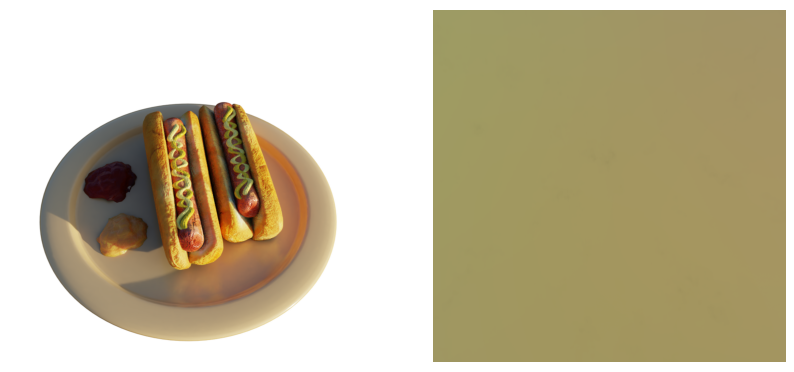

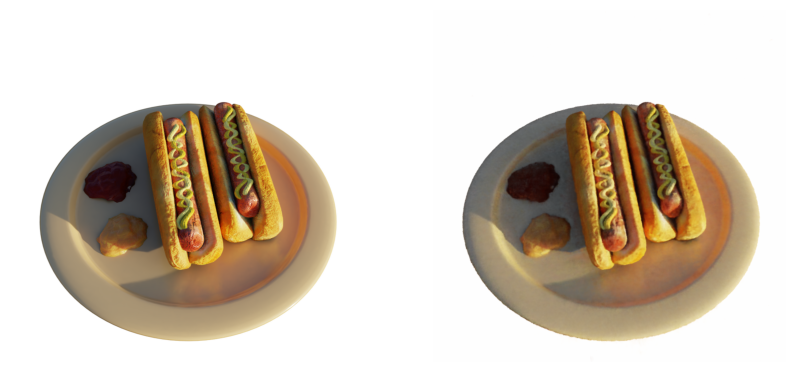

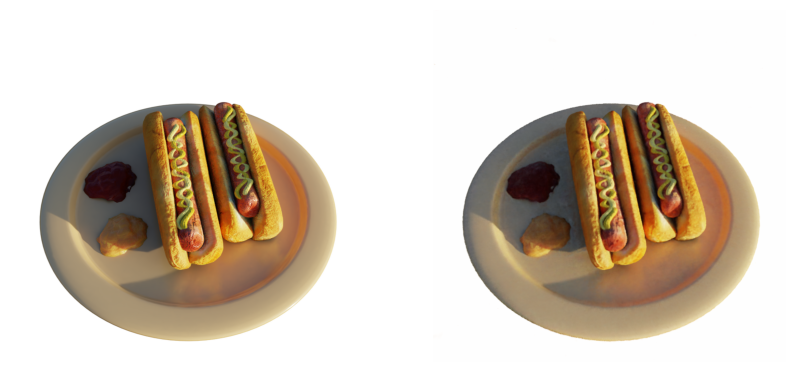

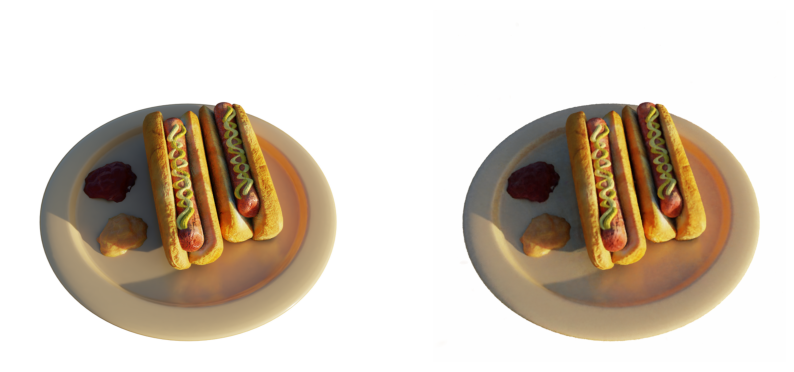

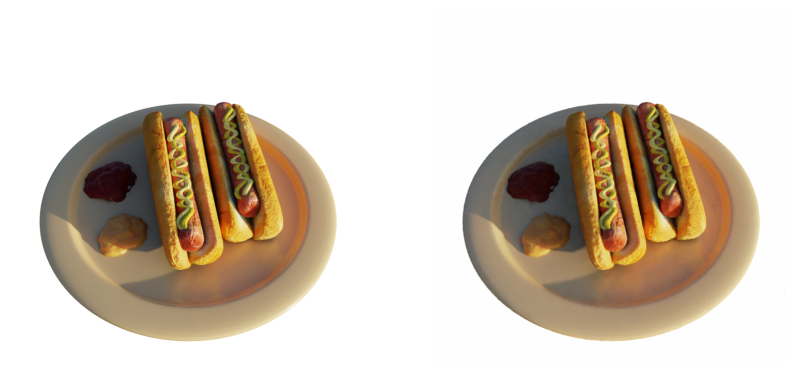

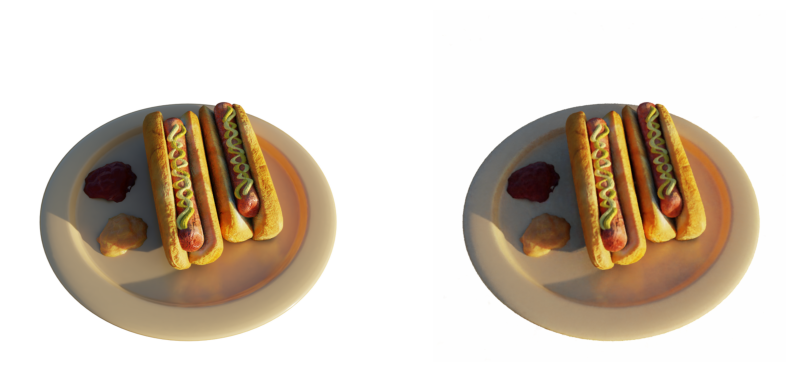

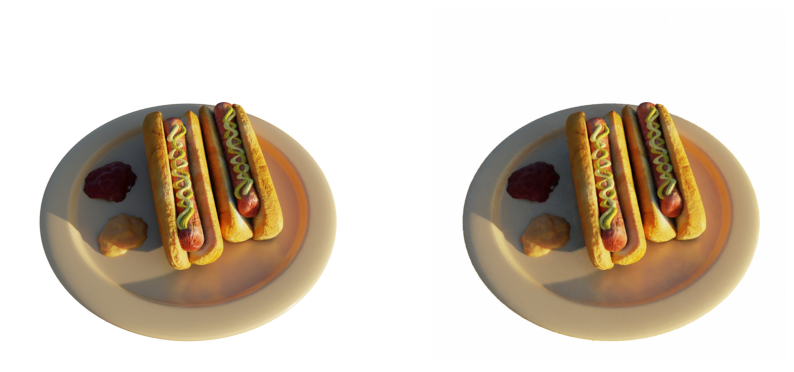

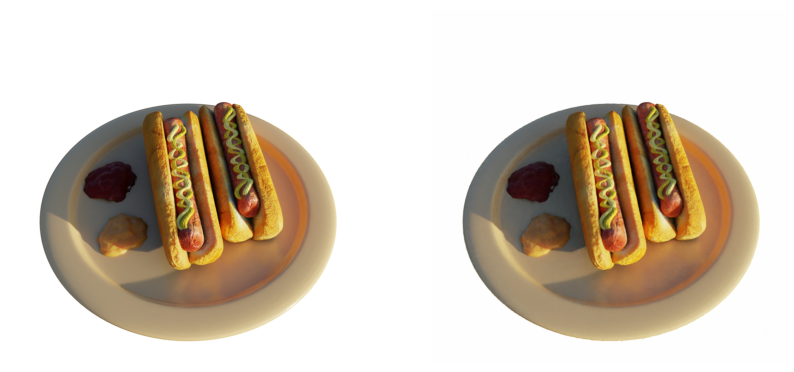

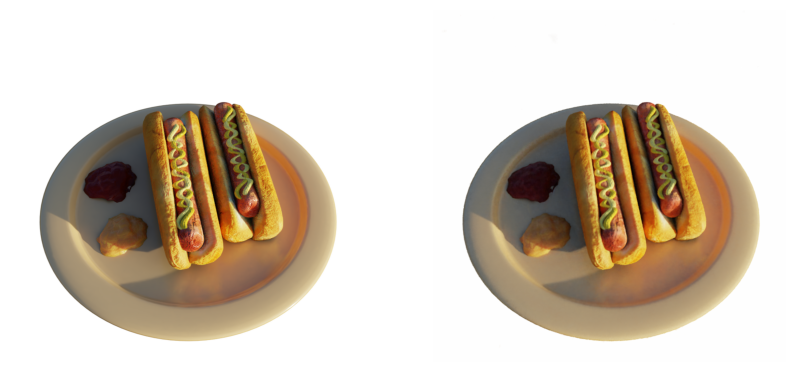

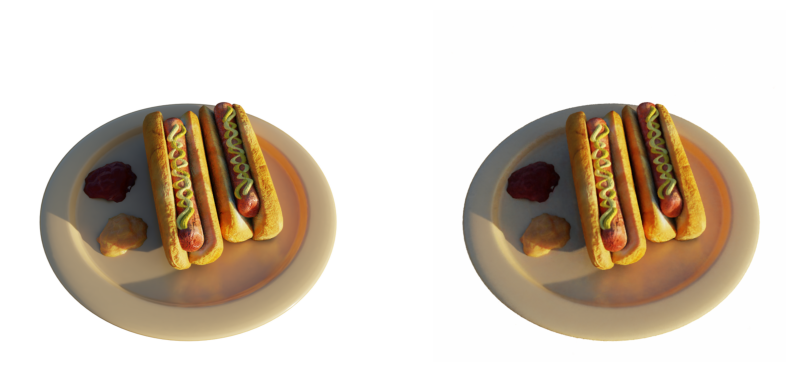

In [4]:
rand_indices_eval_dataloader = RandIndicesEvalDataloader(input_dataset=trainer.pipeline.datamanager.train_dataset)
camera, batch = next(rand_indices_eval_dataloader)
steps = 10000
gaps = steps / 10
for step in trange(0, steps):
    trainer.step = step

    trainer.pipeline.train()
    for callback in trainer.callbacks:
        callback.run_callback_at_location(step, location=TrainingCallbackLocation.BEFORE_TRAIN_ITERATION)

    loss, loss_dict, metrics_dict = trainer.train_iteration(step)

    for callback in trainer.callbacks:
        callback.run_callback_at_location(step, location=TrainingCallbackLocation.AFTER_TRAIN_ITERATION)

    if step % gaps == 0:
        outputs = trainer.pipeline.model.get_outputs_for_camera(camera)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(batch['image'])
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(outputs['rgb'])
        plt.axis('off')
        # plt.savefig(f"logs/output_{step}.png")